# The Die Rolling Problem (Python3)

### by Michael Casebolt

In [1]:

import math
import random
import matplotlib.pyplot as plot
import numpy
from ipywidgets import interact

%matplotlib inline

In [2]:
# "fbit" is short for "fractional bit," so called because Bernoulli r.v.s often have less than one bit of entropy.

In [3]:
# Information Pool
information_pool = []

In [4]:
# 'probability' is the probability (known beforehand) that the Bernoulli r.v. is True.
# 'result' is the value of the Bernoulli r.v., either True or False.
def store_information(probability, result):
    information_pool = [(probability, result)] + entropy_pool

In [5]:
# We need an actual source of entropy, in the form of (assumed) random bits.
# The actual source of entropy is a generator function, that returns one random bit at a time.
# For the purposes of analysis, it comes bundled in a dictionary with an integer that keeps track
# of the number of bits accessed so far.

# An entropy source is a (bit_generator, num_bits_consumed) pair.
def make_pseudorandom_entropy_source():
    result = {
        "num_bits_consumed": 0
    }
    
    def make_pseudorandom_bit_generator():
        while True:
            result["num_bits_consumed"] += 1
            yield True if random.getrandbits(1) else False
    
    result["bit_generator"] = make_pseudorandom_bit_generator()
    return result

In [6]:
# Test out the entropy source.
zoop = make_pseudorandom_entropy_source()
for i in range(10):
    print(next(zoop["bit_generator"]))
print(zoop["num_bits_consumed"], "bits consumed so far.")

True
True
False
True
True
False
True
False
False
True
10 bits consumed so far.


In [7]:
# Figure out how many bits are necessary to represent at least n different values.
# Basically a base two logarithm.
def bit_span(n):
    bits_required = 0
    test_bit = 1
    while test_bit < n:
        bits_required += 1
        test_bit <<= 1
    return bits_required

# Gather enough random bits such that the bits, when treated as an unsigned integer,
# could be at least as large as n - 1, so that it covers the whole range [0, n).
# Use a redundancy to generate at least 'redundancy' times as many bits.
def gather_bits(entropy_source, n, redundancy=1.0):
    num_bits = math.ceil(bit_span(n) * redundancy)
    bits = 0
    positioned_bit = 1
    for bit_index in range(num_bits):
        if next(entropy_source["bit_generator"]):
            bits |= positioned_bit
        positioned_bit <<= 1
    return bits

In [8]:
# Test it out
foo = make_pseudorandom_entropy_source()
print(gather_bits(foo, 123))
print(foo["num_bits_consumed"], "bits consumed so far.")

103
7 bits consumed so far.


In [9]:
# Next, we will implement a variety of different die-rolling algorithms
# and compare their entropy usage, both in theory and by running some experiments.

In [10]:
# Gather the minimum number of bits required, then perform a modulo
# on the random bits and return the result.
def modulo_die_roller(entropy_source, n):
    return gather_bits(entropy_source, n) % n

In [11]:
# Test it out
foo = make_pseudorandom_entropy_source()
print(modulo_die_roller(foo, 123)) # 7 bits required
print(foo["num_bits_consumed"], "bits consumed so far.")

60
7 bits consumed so far.


In [18]:
# use matplotlib to plot the modulo function, to show that it's not fair.
def plot_modulo_function(n):
    num_values = 1 << bit_span(n)
    values = [i % n for i in range(num_values)]
    plot.plot(values, 'ro')
    
    # TODO: show a histogram on the right side of the plot, lined up with the markers

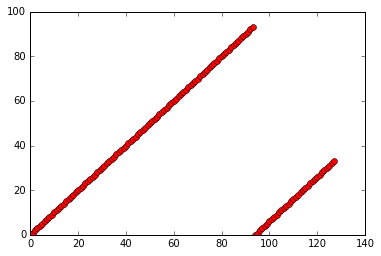

In [20]:
interact(plot_modulo_function, n=(0, 600, 1))

In [21]:
# Same as above, but use extra bits to improve the fairness.
def generous_modulo_die_roller(entropy_source, n, redundancy):
    assert redundancy >= 1.0
    return gather_bits(entropy_source, n, redundancy) % n

In [22]:
# It's still not fair, but it's closer.
# As redundancy increases, fairness increases, but at the cost of using more entropy.
def plot_generous_modulo_function(n, redundancy):
    num_bits = math.ceil(bit_span(n) * redundancy)
    num_values = 1 << num_bits
    values = [i % n for i in range(num_values)]
    plot.plot(values, 'ro')

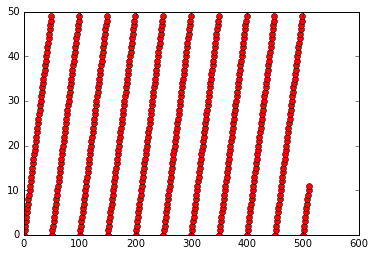

In [28]:
plot_generous_modulo_function(50, 1.4)

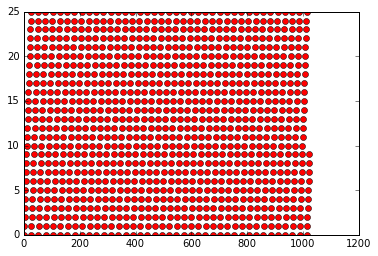

In [30]:
interact(plot_generous_modulo_function, n=(0, 75, 1), redundancy=(1.0, 2.0, 0.05))

If every "run" of the graph had the same number of dots (values) then
the die rolling algorithm would be perfectly fair (assuming the random bits were also perfectly fair).
However, this will only occur if n is a perfect power of 2, in which case
we wouldn't need to use the modulo function anyway: we could just return
a string (sequence) of $log_2(n)$ random bits.

In [106]:
# TODO: plot redundancy versus estimated fairness with lots of data

In [150]:
def rejection_sampling_die_roller(entropy_source, n):
    while True:
        random_bits = gather_bits(entropy_source, n)
        if random_bits < n:
            return random_bits

In [151]:
def generous_rejection_sampling_die_roller(entropy_source, n, redundancy):
    num_bits = bit_span(n)
    # There are exactly n * M values <= n, where M is a positive integer.
    max_accepted_value = ((1 << bits_to_use) // n) * n - 1
    while True:
        random_bits = gather_bits(entropy_source, n, redundancy)
        if random_bits <= max_accepted_value:
            return random_bits

In [152]:
# TODO: graphs

In [ ]:
# TODO: look back at methods so far, summarize pros and cons
# recognize tradeoff between fairness, runtime, and entropy usage.


In [ ]:
# TODO: more entropy-efficient methods

In [1]:
def range_encode(sequence, limits):
    assert type(sequence) is list or type(sequence) is iter
    assert type(limits) is list or type(limits) is iter
    assert len(sequence) <= len(limits)
    
    if type(sequence) is list:
        sequence = iter(sequence)
    
    if type(limits) is list:
        limits = iter(limits)
    
    encoded = 0
    factor = 1
    for value in sequence:
        next_limit = next(limits)
        if value >= next_limit:
            raise Exception("Error: each value[n] must be in range(limit[n])")
        
        encoded += value * factor
        factor *= next_limit
    
    return encoded

In [2]:
def range_decode(encoded, limits):
    assert type(limits) is list or type(limits) is iter
    
    result = []
    for limit in limits:
        result.append(encoded % limit)
        encoded //= limit

    return result